## Initialization and cell division

In [1]:
from shared.preface import *

In [1]:
# See how much memory is used by OS initially.
# Then substract this value from later mem used, to obtain mem used by scripts.
import psutil
GB_UNIT = 1000*1024**2
MB_UNIT = GB_UNIT/1e3
OS_MEM = psutil.virtual_memory().used
print(OS_MEM/GB_UNIT)


from shared.preface import *
import shared.functions as fct


# Initialize parameters and files.
PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=10000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)
TEMP_DIR = f'X_tests'


# benchmark = True
benchmark = False

if benchmark:
    zval = PRE.ZEDS_SNAPS[::-1][0]
    snap = PRE.NUMS_SNAPS[::-1][0]
    halo_Mvir = np.log10(Mvir_MW/Msun)
    halo_rvir = ((Mvir_MW/(200*fct.rho_crit(zval)*4.*Pi/3.))**(1./3.))/kpc
    halo_cNFW = fct.c_vir(zval, Mvir_MW, halo_rvir*kpc, Rs_MW)

    DM_raw = np.load(f'{PRE.OUT_DIR}/benchmark_halo_snap_{snap}.npy')
    IDname = f'benchmark_halo_snap_{snap}'

else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 5

    hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
    fct.halo_batch_indices(
        PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
        hname, PRE.SIM_DIR, TEMP_DIR
    )

    halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
    halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
    halo_num = len(halo_batch_params)

    print('********Number density band********')
    print('Halo batch params (Rvir,Mvir,cNFW):')
    print(halo_batch_params)
    print('***********************************')

    # Select halo and its parameters.
    halo_j = 1
    halo_ID = halo_batch_IDs[halo_j]
    halo_rvir = halo_batch_params[halo_j, 0]
    halo_Mvir = halo_batch_params[halo_j, 1]
    halo_cNFW = halo_batch_params[halo_j, 2]

    # Generate progenitor index array for current halo.
    splits = re.split('/', SIM_TYPE)
    MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
    proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)

    # Find DM belonging to halo in chosen snapshot.
    j = 0
    snap = PRE.NUMS_SNAPS[::-1][0]
    proj_ID = proj_IDs[0]
    proj_ID = int(proj_ID)

    IDname = f'origID{halo_ID}_snap_{snap}'
    fct.read_DM_halo_index(
        snap, proj_ID, IDname, PRE.SIM_DIR, TEMP_DIR
    )
    DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')


# Number of DM particles in halo.
DM_particles = len(DM_raw)

# Generate cell grid.
cell_coords, DM_count, cell_com, cell_gen, snap_GRID_L = fct.halo_to_grid(
    DM_raw, PRE.DM_LIM, IDname, TEMP_DIR
)

# From DM_raw to DM_pos.
cells = len(cell_coords)
DM_pos = np.expand_dims(DM_raw*kpc, axis=0)
del DM_raw

23.2719609375
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 10000
DM mass of sim box in log10 Msun: 6.1577
Smoothening length of sim box in kpc: 0.65
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]
 [158.62979351  11.62953177   8.03988676]
 [137.07912107  11.43929142   9.41292697]
 [141.82849159  11.48366794   2.6088865 ]
 [306.35586267  12.48705608  11.48652354]]
***********************************


### Sanity checks.

In [2]:
ic(cells)
ic(DM_particles)

ic| cells: 197
ic| DM_particles: 235953


235953

0.7961865394047041


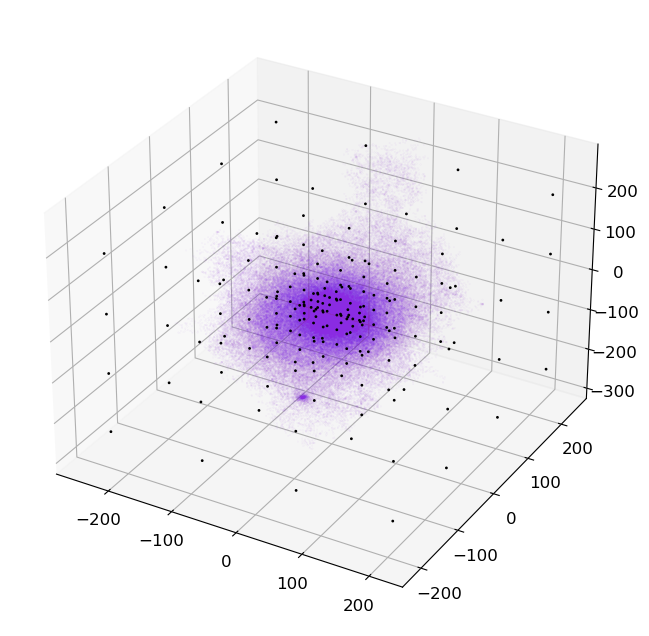

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
step = 10
x, y, z = DM_pos[...,0][::step], DM_pos[...,1][::step], DM_pos[...,2][::step]
ax.scatter(x/kpc,y/kpc,z/kpc, alpha=0.5, c='blueviolet', s=0.001, label='DM')
x, y, z, = cell_coords[:,0], cell_coords[:,1], cell_coords[:,2]
ax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='black', s=1, label='cell_coords')

# Figure for sanity check: Both the cell centers and c.o.m. are centered w.r.t. 
# the origin of the halo, i.e. on (0,0,0).

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x, y, z = cell_coords[:,0], cell_coords[:,1], cell_coords[:,2]
# ax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='black', s=1, label='cell_coords')
# x, y, z = cell_com[:,0], cell_com[:,1], cell_com[:,2]
# ax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='red', s=1, label='cell_com')

# Here is the reason, why beyond the virial radius, the ratio of the cell 
# gravity and NFW has a different value than one. NFW uses the virial mass, 
# whereas my implementation uses the total mass of all DM particles of the halo.

mass1 = 10**halo_Mvir
mass2 = PRE.DM_SIM_MASS*DM_particles/Msun
print(mass2/mass1)
# The last ratio is exactly what we can see (outside the virial radius) with 
# the gravity_comparison_NFW function below.

## Short-range gravity.

In [4]:
def chunksize_short_range(cells, DM_tot, max_DM_lim, core_mem_MB):

    # note: mem_MB specific to peak memory usage in cell_gravity_short_range.
    # -> Peak memory after calculation of ind_2D,ind_3D,etc. sorting arrays.

    elem = 8                               # 8 bytes for standard np.float64
    mem_type0 = cells*3 * elem             # for list to ndarray of cell_coords
    mem_type1 = cells*DM_tot * elem        # for ind_2D
    mem_type2 = cells*DM_tot*3 * elem      # for DM_pos_sync, ind_3D, DM_sort
    mem_type3 = cells*max_DM_lim*3 * elem  # for DM_in

    mem_MB = (mem_type0+mem_type1+(3*mem_type2)+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize


def batch_generators_short_range(cell_coords, cell_gen, chunksize):

    cells = len(cell_coords)

    batches = math.ceil(cells/chunksize)
    batch_arr = np.arange(batches)

    cell_chunks = list(chunks(chunksize, cell_coords))
    cgen_chunks = list(chunks(chunksize, cell_gen))
    
    return batch_arr, cell_chunks, cgen_chunks


def cell_gravity_short_range(
    cell_coords_in, cell_gen, init_GRID_S,
    DM_pos, DM_lim, DM_sim_mass, smooth_l,
    out_dir, b_id, max_b_len
):

    cell_coords = np.expand_dims(np.array(cell_coords_in), axis=1)
    cell_gen = np.array(cell_gen)

    # Center all DM positions w.r.t. cell center.
    # DM_pos already in shape = (1, DM_particles, 3)
    DM_pos_sync = np.repeat(DM_pos, len(cell_coords), axis=0)
    DM_pos_sync -= cell_coords

    # Cell lengths to limit DM particles. Limit for the largest cell is 
    # GRID_S/2, not just GRID_S, therefore the cell_gen+1 !
    cell_len = np.expand_dims(init_GRID_S/(2**(cell_gen+1)), axis=1)
    
    # Select DM particles inside each cell based on cube length generation.
    DM_in_cell_IDs = np.asarray(
        (np.abs(DM_pos_sync[...,0]) < cell_len) & 
        (np.abs(DM_pos_sync[...,1]) < cell_len) & 
        (np.abs(DM_pos_sync[...,2]) < cell_len)
    )
    #? < results in 1 missing DM particle. Using <= though overcounts
    #? is there a way to get every DM particle by adjusting rtol and atol ?
    # note: -> not pressing for now however
    del cell_gen, cell_len

    # Set DM outside cell to nan values.
    DM_pos_sync[~DM_in_cell_IDs] = np.nan

    # Save the DM IDs, such that we know which particles are in which cell.
    # This will be used in the long-range gravity calculations.
    DM_in_cell_IDs_compact = np.argwhere(DM_in_cell_IDs==True)
    DM_in_cell_IDs_compact[:,0] += (max_b_len*b_id)
    
    del DM_in_cell_IDs
    np.save(f'{out_dir}/batch{b_id}_DM_in_cell_IDs.npy', DM_in_cell_IDs_compact)
    del DM_in_cell_IDs_compact

    # Sort all nan values to the bottom of axis 1, i.e. the DM-in-cell-X axis 
    # and truncate array based on DM_lim parameter. This simple way works since 
    # each cell cannot have more than DM_lim (times the last shell multiplier).
    ind_2D = DM_pos_sync[:,:,0].argsort(axis=1)
    ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)
    DM_sort = np.take_along_axis(DM_pos_sync, ind_3D, axis=1)
    DM_in = DM_sort[:,:DM_lim*SHELL_MULTIPLIERS[-1],:]
    
    # note: Visual to see, if DM_in is grouped into the right cells.
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ss = 5
    # for elem in (DM_in+cell_coords)/kpc:
    #     x, y, z = elem[:,0][::ss], elem[:,1][::ss], elem[:,2][::ss]
    #     ax.scatter(x,y,z, alpha=0.5, s=0.5)

    # ss = 100
    # x, y, z = DM_pos[...,0][::ss], DM_pos[...,1][::ss], DM_pos[...,2][::ss]
    # ax.scatter(x/kpc,y/kpc,z/kpc, alpha=0.1, c='blueviolet', marker='x', s=0.001)
    # ax.view_init(elev=90, azim=20)
    # plt.show()

    # note: Memory peaks here, due to these arrays:
    # print(DM_pos_sync.shape, ind_2D.shape, ind_3D.shape, DM_sort.shape, DM_in.shape)
    # mem_inc = gso(cell_coords)+gso(DM_pos_sync)+gso(ind_2D)+gso(ind_3D)+gso(DM_sort)+gso(DM_in)
    # print('MEM_PEAK:', mem_inc/1e6)
    del DM_pos_sync, ind_2D, ind_3D, DM_sort

    # Calculate distances of DM and adjust array dimensionally.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_in**2, axis=2)), axis=2)

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.

    # Quotient in sum (see formula). Can contain nan values, thus the np.nansum 
    # for the derivative, s.t. these values don't contribute. We center DM on 
    # c.o.m. of cell C, so we only need DM_in in numerator.
    #? does DM_in also need to be shifted by eps?
    quot = (-DM_in)/np.power((DM_dis**2 + eps**2), 3./2.)
    
    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.nansum(quot, axis=1)    
    np.save(f'{out_dir}/batch{b_id}_short_range.npy', derivative)


# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine short-range chuncksize based on available memory and cells.
chunksize_sr = chunksize_short_range(
    cells, DM_particles, PRE.DM_LIM*SHELL_MULTIPLIERS[-1], core_mem_MB
)

# Split workload into batches (if necessary).
batch_arr, cell_chunks, cgen_chunks = batch_generators_short_range(
    cell_coords, cell_gen, chunksize_sr
)

single = False

if single:
    # Memory profile the short-range gravity function.
    cell_index = 10
    in1 = cell_chunks[cell_index]
    in2 = cgen_chunks[cell_index]
    in3 = batch_arr[cell_index]

    cell_gravity_short_range(
        in1, in2, snap_GRID_L,
        DM_pos, PRE.DM_LIM, PRE.DM_SIM_MASS, PRE.SMOOTH_L, 
        TEMP_DIR, in3, chunksize_sr
    )
else:
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_short_range, 
            cell_chunks, cgen_chunks, repeat(snap_GRID_L), 
            repeat(DM_pos), repeat(PRE.DM_LIM), repeat(PRE.DM_SIM_MASS), 
            repeat(PRE.SMOOTH_L), repeat(TEMP_DIR), batch_arr, 
            repeat(chunksize_sr)
        )

    # Combine short-range batch files.
    dPsi_short_range_batches = [
        np.load(f'{TEMP_DIR}/batch{b}_short_range.npy') for b in batch_arr
    ]
    dPsi_short_range = np.array(
        list(chain.from_iterable(dPsi_short_range_batches))
    )
    np.save(
        f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy', 
        dPsi_short_range
    )

    # Combine DM_in_cell_IDs batches.
    DM_in_cell_IDs_l = []
    for b_id in batch_arr:
        DM_in_cell_IDs_l.append(
            np.load(f'{TEMP_DIR}/batch{b_id}_DM_in_cell_IDs.npy')
        )
    DM_in_cell_IDs_np = np.array(list(chain.from_iterable(DM_in_cell_IDs_l)))
    np.save(
        f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy', 
        DM_in_cell_IDs_np
    )

Per core mem (GB): 1.7481150512695312


## Long-range gravity.

In [5]:
def chunksize_long_range(cells, core_mem_MB):
    
    # note: mem_MB specific to peak memory usage in cell_gravity_long_range.
    # -> Peak memory after calculation of derivative.

    elem = 8                          # 8 bytes for standard np.float64
    mem_type1 = 3*elem                # for derivative
    mem_type2 = cells*3*elem          # for quot
    mem_type3 = cells*elem            # for DM_count_sync

    mem_MB = (mem_type1+mem_type2+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize
    

def batch_generators_long_range(
    cell_coords, com_coords, cell_gen, 
    DM_counts, chunksize 
):

    # Cell number, chunksize and resulting number of batches.
    cells = len(cell_coords)
    cell_nums = np.arange(cells)
    batches = math.ceil(cells/chunksize)


    ### ------- ###
    ### Arrays. ###
    ### ------- ###

    # Arrays are repeated/tiled to match length & number of batches.

    batch_IDs = np.tile(np.arange(batches), cells)  # batch labels/indices
    # [0,...,batches,0,...,batches,...]
    
    cellC_rep = np.repeat(cell_nums, batches)  # cell labels/indices
    # [0,...,0,1,...,1,...,cells-1,...,cells-1]

    cellC_cc = np.repeat(cell_coords, batches, axis=0)  # cell coordinates
    # [[x1,y1,z1],...,[x1,y1,z1],...]

    cellC_gen = np.repeat(cell_gen, batches)  # cell generations
    # e.g. [0,...,0,0,...,0,1,...1,...], ... repeated to match nr of batches

    ### ----------- ###
    ### Generators. ###
    ### ----------- ###

    # We split up all arrays into smaller chunks, s.t. each batch gets a 
    # smaller set of cells. Generators are used to benefit from the chunks() 
    # function, then converted to lists (map() will do this anyway).
    
    # We do this for:
    # 1. the cell_IDs of cells present in a batch, 
    # 2. the DM counts of all cells in a batch, 
    # 3. the c.o.m. coords of all cells in a batch,
    # 4. the (cell division) generation index for all cells in a batch:

    # 1. 
    cib_IDs = list(
        (c for _ in cell_nums for c in chunks(chunksize, cell_nums)))

    # 2.
    counts = list(
        (c for _ in cell_nums for c in chunks(chunksize, DM_counts)))

    # 3.
    coms = list(
        (c for _ in cell_nums for c in chunks(chunksize, com_coords)))

    # 4.
    gens = list(
        (c for _ in cell_nums for c in chunks(chunksize, cell_gen)))

    return batch_IDs, cellC_rep, cellC_cc, cellC_gen, \
        cib_IDs, counts, coms, gens


def load_dPsi_long_range(c_id, batches, out_dir):

    # Load all batches for current cell.
    dPsi_raw = np.array(
        [np.load(f'{out_dir}/cell{c_id}_batch{b}_long_range.npy') for b in batches]
    )

    # Combine into one array by summing and save.
    dPsi_for_cell = np.sum(dPsi_raw, axis=0)
    np.save(f'{out_dir}/cell{c_id}_long_range.npy', dPsi_for_cell)  


def cell_gravity_long_range_quadrupole(
    c_id, cib_ids, b_id, cellC_cc, cell_com, cell_gen, init_GRID_S,
    DM_pos, DM_count, DM_in_cell_IDs, DM_sim_mass, out_dir, 
    max_b_len, cellC_gen
):
    # Prefix "cellC" denotes the cell to calculate the long-range forces for.

    # Convert the list inputs to numpy arrays.
    cib_ids = np.array(cib_ids)
    cell_com = np.array(cell_com)
    cell_gen = np.array(cell_gen)
    DM_count = np.array(DM_count)

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ss = 50
    # x, y, z = DM_pos[:,0][::ss], DM_pos[:,1][::ss], DM_pos[:,2][::ss]
    # ax.scatter(x,y,z, alpha=0.8, c='blueviolet', s=0.01)
    # plt.show()

    # Array, where cell C is centered on c.o.m. coords. of all cells.
    cellC_sync = np.repeat(
        np.expand_dims(cellC_cc, axis=0), len(cell_com), axis=0
    ) 
    cellC_sync -= cell_com

    # Get (complete, not half) cell length of all cells and current cell C.
    cell_len = init_GRID_S/(2**(cell_gen))
    cellC_len = init_GRID_S/(2**(cellC_gen))

    # Distance of cellC to all cell_com's.
    cellC_dis = np.sqrt(np.sum(cellC_sync**2, axis=1))

    # note: different criterium, based on cells inside sphere around cell C.
    r_crit = 1.5*cellC_len*((cellC_gen+1)**0.6)
    # r_crit = -1.  # for no multipole cells
    multipole_IDs = np.argwhere(cellC_dis <= r_crit).flatten()
    monopole_IDs = np.argwhere(cellC_dis > r_crit).flatten()

    if c_id in cib_ids:
        # Overwrite element corresponding to cell C from all arrays, to avoid
        # self-gravity of the cell (taken care of by short-range gravity).

        # First find the correct index for the current cell. We have to take 
        # this akin to a "modulo" according to the maximum batch length. E.g. 
        # if the max. batch length is 100, but we are at cell label/index 100, 
        # then this would be index '0' again for arrays in this function.
        cellC_idx = (c_id - (max_b_len*b_id))

        # Set cell C array element(s) to 0 or nan, s.t. it just adds 0 later on.
        cell_com[cellC_idx] = np.nan  # c.o.m. of cell C to [nan,nan,nan]
        cell_len[cellC_idx] = 0  # 0 cell length
        DM_count[cellC_idx] = 0  # 0 DM count

        # If cell C has 0 DM, then its c.o.m == coords., so set cellC_dis to 1.
        # (avoids divide by zero in these (edge) cases later on)
        if cellC_dis[cellC_idx] == 0:
            cellC_dis[cellC_idx] = 1

    # region
    # note: until further understood, this the angle criterium doesn't work.
    # Determine which cells are close enough and need multipole expansion:    
    # Cells with angle larger than the critical angle are multipole cells.
    # The critical angle is dependent on the cell length of cell C.
    # (see GoodNotes for why 0.3 exponent for now)
    # theta = cell_len / cellC_dis
    # theta_crit = 1/(1.5*((cellC_gen+1)**0.3))
    # theta_crit = 1/(1.5*cellC_len*((cellC_gen+1)**0.3))
    # theta_crit = 1e10  # large, s.t. only monopole cells

    # Find IDs for cells, for which we additionally calculate the quadrupole.
    # Cell C will be a monopole-only cell, but with its DM count set to 0, so 
    # it won't contribute later.
    # multipole_IDs = np.argwhere(theta >= theta_crit).flatten()
    # monopole_IDs = np.argwhere(theta < theta_crit).flatten()

    # Save positions for plotting.
    # np.save(f'{out_dir}/monopoles_cc_batch{b_id}.npy', monopole_IDs + (max_b_len*b_id))
    # np.save(f'{out_dir}/multipoles_cc_batch{b_id}.npy', multipole_IDs + (max_b_len*b_id))
    # endregion

    # DM count for multipole cells.
    DM_count_mpoles = DM_count[multipole_IDs]

    # All DM particles (their positions), which are in multipole cells.
    # Adjust/match multipole_IDs first, since they are limited to size of batch.
    comparison_IDs = multipole_IDs + (max_b_len*b_id)
    DM_IDs = DM_in_cell_IDs[np.in1d(DM_in_cell_IDs[:,0], comparison_IDs)][:,1]
    # DM_pos_mpoles = DM_pos[np.in1d(np.arange(len(DM_pos)), DM_IDs)] #! wrong
    DM_pos_mpoles = np.take(DM_pos, DM_IDs, axis=0)

    # Split this total DM array into DM chunks present in each multipole cell:
    # We can do this by breaking each axis into sub-arrays, with length 
    # depending on how many DM particles are in each cell (which is stored in 
    # DM_count of multipole cells, i.e. DM_count_mpoles).
    
    # Special case, where all multipole cells have no DM.
    # (This can happen e.g. if cell C is an outermost cell)
    if np.all(DM_count_mpoles==0):
        DM_mpoles = np.full(shape=(len(multipole_IDs),1,3), fill_value=np.nan)

    # "Normal" case, where some or all multipole cells contain DM.
    else:
        breaks = np.cumsum(DM_count_mpoles[:-1])
        ax0_split = np.split(DM_pos_mpoles[:,0], breaks)
        ax1_split = np.split(DM_pos_mpoles[:,1], breaks)
        ax2_split = np.split(DM_pos_mpoles[:,2], breaks)

        # Fill each axis with nans to obtain dimensionally valid ndarray.
        DM_axis0 = np.array(list(zip_longest(*ax0_split, fillvalue=np.nan))).T
        DM_axis1 = np.array(list(zip_longest(*ax1_split, fillvalue=np.nan))).T
        DM_axis2 = np.array(list(zip_longest(*ax2_split, fillvalue=np.nan))).T

        # Recombine all axes into one final DM positions array.
        DM_mpoles = np.stack((DM_axis0, DM_axis1, DM_axis2), axis=2)
        del ax0_split, ax1_split, ax2_split, DM_axis0, DM_axis1, DM_axis2    


    # Select c.o.m. of multipole cells and adjust dimensionally.
    mpoles_com = np.expand_dims(cell_com[multipole_IDs], axis=1)

    #? Cannot verify that DM positions sum to zero correctly...
    # DM_nansum = np.nansum(DM_mpoles, axis=1)
    # count_sync = np.repeat(np.expand_dims(DM_count_mpoles, axis=1), 3, axis=1)
    # com_sync = np.squeeze(mpoles_com, axis=1)
    # trace_check = DM_nansum - count_sync*com_sync

    # cell_1x = 2
    # DM_1x = DM_mpoles[cell_1x,:,0]
    # com_1x = mpoles_com[cell_1x,:,0]
    # trace_1x = np.nansum(DM_1x) - DM_count_mpoles[cell_1x]*com_1x

    # print(trace_1x)
    # print(trace_check)

    # Center DM in multipole cells (labeled with "J") on their c.o.m. coords.
    DM_mpoles -= mpoles_com

    # note: Plotting DM particles with colors in each cell.
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ss = 10
    # for elem in (DM_mpoles+mpoles_com)/kpc:
    #     x, y, z = elem[:,0][::ss], elem[:,1][::ss], elem[:,2][::ss]
    #     ax.scatter(x,y,z, alpha=0.5, s=1)

    # x, y, z = mpoles_com[...,0], mpoles_com[...,1], mpoles_com[...,2]
    # ax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='black', marker='x', s=20)
    # ax.view_init(elev=15, azim=15)
    # plt.show()

    # Calculate distances of all DM in J cells from their c.o.m. coord.
    DMj_dis = np.expand_dims(np.sqrt(np.sum(DM_mpoles**2, axis=2)), axis=2)
    
    # Array, where cell C is centered on c.o.m. coords. of J cells.
    cellC_Jcoms = np.repeat(
        np.expand_dims(cellC_cc, axis=(0,1)), 
        len(mpoles_com), axis=0
    )
    cellC_Jcoms -= mpoles_com

    # Distance of cell C to c.o.m. of multipole cells.
    cellC_Jdis = np.sqrt(np.sum(cellC_Jcoms**2, axis=2))

    ### -------------------- ###
    ### Quadrupole formulas. ###
    ### -------------------- ###
    # See GoodNotes for notation.

    # Terms appearing in the quadrupole term.
    QJ_aa = np.nansum(3*DM_mpoles**2 - DMj_dis**2, axis=1)
    QJ_ab = np.nansum(3*DM_mpoles*np.roll(DM_mpoles, 1, axis=2), axis=1)

    # Reduce dimensions.
    cellC_Jcoms = np.squeeze(cellC_Jcoms, axis=1)
    cellC_Jdis_1D = np.squeeze(cellC_Jdis, axis=1)
    
    # Permute order of coords by one, i.e. (x,y,z) -> (z,x,y).
    cellC_Jcoms_roll = np.roll(cellC_Jcoms, 1, axis=1)

    # Factors of 2 are for the symmetry of QJ_ab elements.
    term1_aa = np.nansum(QJ_aa*cellC_Jcoms, axis=1)
    term1_ab = np.nansum(2*QJ_ab*cellC_Jcoms_roll, axis=1)
    term1 = np.expand_dims((term1_aa+term1_ab)/cellC_Jdis_1D**5, axis=1)

    term2_pre = 5*cellC_Jcoms/(2*cellC_Jdis**7)
    term2_aa = np.nansum(QJ_aa*cellC_Jcoms**2, axis=1)
    term2_ab = np.nansum(2*QJ_ab*cellC_Jcoms*cellC_Jcoms_roll, axis=1)
    term2 = term2_pre*np.expand_dims(term2_aa+term2_ab, 1)

    dPsi_multipole_cells = G*DM_sim_mass*np.nansum(-term1+term2, axis=0)
    
    ### ---------------------- ###
    ### Monopole of all cells. ###
    ### ---------------------- ###

    mono_com = np.expand_dims(cell_com, axis=1)

    # Array, where cell C is centered on c.o.m. coords. of monopole cells.
    cellC_Jcoms_mono = np.repeat(
        np.expand_dims(np.expand_dims(cellC_cc, axis=0), axis=0), 
        len(mono_com), axis=0
    )
    cellC_Jcoms_mono -= mono_com

    # Distance of cell C to c.o.m. of monopole cells.
    cellC_dis_mono = np.sqrt(np.sum(cellC_Jcoms_mono**2, axis=2))
    
    # Long-range force of all cells due to monopole.
    cellC_Jcoms_mono_2D = np.squeeze(cellC_Jcoms_mono, axis=1)
    DM_count_mono_sync = np.expand_dims(DM_count, axis=1)
    dPsi_monopole_cells = G*DM_sim_mass*np.nansum(
        DM_count_mono_sync*cellC_Jcoms_mono_2D/(cellC_dis_mono**3), axis=0)

    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative_lr = -(dPsi_multipole_cells + dPsi_monopole_cells)
    
    np.save(f'{out_dir}/cell{c_id}_batch{b_id}_long_range.npy', derivative_lr)



# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine long-range chuncksize based on available memory and cells.
# chunksize_lr = chunksize_long_range(cells, core_mem_MB)
chunksize_lr = 200

# Split workload into batches (if necessary).
DM_in_cell_IDs = np.load(f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy')
batch_IDs, cellC_rep, cellC_cc, gen_rep, cib_IDs_gens, count_gens, com_gens, gen_gens = batch_generators_long_range(
    cell_coords, cell_com, cell_gen, DM_count, chunksize_lr
)

single = False

if single:
    # Memory profile the long-range gravity function.
    cell_index = -2
    c_id = cellC_rep[cell_index]
    cib_ids = cib_IDs_gens[cell_index]
    b_id = batch_IDs[cell_index]
    cellC_cc = cellC_cc[cell_index]
    count_gen = count_gens[cell_index]
    com_gen = com_gens[cell_index]
    gen_gen = gen_gens[cell_index]
    cellC_gen = gen_rep[cell_index]

    # load_dPsi_long_range(c_id, np.unique(batch_IDs), TEMP_DIR)

    cell_gravity_long_range_quadrupole(
        c_id, cib_ids, b_id, cellC_cc, com_gen, gen_gen, snap_GRID_L,
        np.squeeze(DM_pos, axis=0), count_gen, DM_in_cell_IDs, 
        PRE.DM_SIM_MASS, TEMP_DIR, chunksize_lr, cellC_gen
    )

    output_lr = np.load(f'{TEMP_DIR}/cell{c_id}_batch{b_id}_long_range.npy')
    print('OUTPUT:', output_lr, np.sqrt(np.sum(output_lr**2)))
else:
    # Pass arrays and chains of generators to multiprocessing routine.
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_long_range_quadrupole, 
            cellC_rep, cib_IDs_gens, batch_IDs, 
            cellC_cc, com_gens, gen_gens, repeat(snap_GRID_L),
            repeat(np.squeeze(DM_pos, axis=0)), count_gens, 
            repeat(DM_in_cell_IDs), repeat(PRE.DM_SIM_MASS), 
            repeat(TEMP_DIR), repeat(chunksize_lr), gen_rep
        )

    # Combine long-range batch files.
    cell_labels = np.unique(cellC_rep)
    batch_labels = np.unique(batch_IDs)
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            load_dPsi_long_range, cell_labels, 
            repeat(batch_labels), repeat(TEMP_DIR)
        )

    # Save long-range gravity (a [x,y,z] array) for all cells.
    dPsi_lr = np.array(
        [np.load(f'{TEMP_DIR}/cell{c}_long_range.npy') for c in cell_labels])
    np.save(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy', dPsi_lr)

Per core mem (GB): 1.7479862365722656


## Plotting.

### 3D plots of which cells are mono- or multipole cells, for chosen cell. 
(some files have to be created in long-range gravity function above for this cell to work)

In [6]:
'''
%matplotlib inline

# Load monopole and multipole IDs from batches. For last cell.
mono0 = np.load(f'{TEMP_DIR}/monopoles_cc_batch0.npy')
mono1 = np.load(f'{TEMP_DIR}/monopoles_cc_batch1.npy')
mono_tot = np.concatenate((mono0,mono1))
multi0 = np.load(f'{TEMP_DIR}/multipoles_cc_batch0.npy')
multi1 = np.load(f'{TEMP_DIR}/multipoles_cc_batch1.npy')
multi_tot = np.concatenate((multi0,multi1))

mono_cc = cell_coords[mono_tot]
multi_cc = cell_coords[multi_tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Chosen cell C coordinate.
Cid = 0
x, y, z = cell_coords[Cid,0]/kpc, cell_coords[Cid,1]/kpc, cell_coords[Cid,2]/kpc
ax.scatter(x,y,z, alpha=1, c='orange', s=20, label=f'{x},{y},{z}')

# All cell coords.
x, y, z = cell_coords[:,0], cell_coords[:,1], cell_coords[:,2]
ax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='black', s=1, label='cell_coords')

# Monopole cell coords.
x, y, z = mono_cc[:,0], mono_cc[:,1], mono_cc[:,2]
ax.scatter(x/kpc,y/kpc,z/kpc, alpha=0.3, c='green', s=8, label='mono_cc')

# Multipole cell coords.
x, y, z = multi_cc[:,0], multi_cc[:,1], multi_cc[:,2]
ax.scatter(x/kpc,y/kpc,z/kpc, alpha=0.3, c='magenta', s=8, label='multi_cc')

ax.view_init(elev=25, azim=85)
ax.legend()
'''

"\n%matplotlib inline\n\n# Load monopole and multipole IDs from batches. For last cell.\nmono0 = np.load(f'{TEMP_DIR}/monopoles_cc_batch0.npy')\nmono1 = np.load(f'{TEMP_DIR}/monopoles_cc_batch1.npy')\nmono_tot = np.concatenate((mono0,mono1))\nmulti0 = np.load(f'{TEMP_DIR}/multipoles_cc_batch0.npy')\nmulti1 = np.load(f'{TEMP_DIR}/multipoles_cc_batch1.npy')\nmulti_tot = np.concatenate((multi0,multi1))\n\nmono_cc = cell_coords[mono_tot]\nmulti_cc = cell_coords[multi_tot]\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Chosen cell C coordinate.\nCid = 0\nx, y, z = cell_coords[Cid,0]/kpc, cell_coords[Cid,1]/kpc, cell_coords[Cid,2]/kpc\nax.scatter(x,y,z, alpha=1, c='orange', s=20, label=f'{x},{y},{z}')\n\n# All cell coords.\nx, y, z = cell_coords[:,0], cell_coords[:,1], cell_coords[:,2]\nax.scatter(x/kpc,y/kpc,z/kpc, alpha=1, c='black', s=1, label='cell_coords')\n\n# Monopole cell coords.\nx, y, z = mono_cc[:,0], mono_cc[:,1], mono_cc[:,2]\nax.scatter(x/kpc,y/kpc,z/kpc

### Short-range & Long-range gravity comparison.

In [7]:
test_cell = -1
# gEarth = 9.81*m/s**2
gEarth = 1

### For short-range. ###
gravity_sr = np.load(f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy')
print(f'Short range gravity grid shape:', gravity_sr.shape)

mags_sr = np.sqrt(np.sum(gravity_sr**2, axis=1))
print(mags_sr[test_cell]/gEarth)

### For long-range. ###
gravity_lr = np.load(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy')
print(f'Long range gravity grid shape:', gravity_lr.shape)

mags_lr = np.sqrt(np.sum(gravity_lr**2, axis=1))
print(mags_lr[test_cell]/gEarth)

Short range gravity grid shape: (197, 3)
8.68024627000698e-37
Long range gravity grid shape: (197, 3)
2.106474519925878e-35


min/max: 7.24e-37/1.02e+04


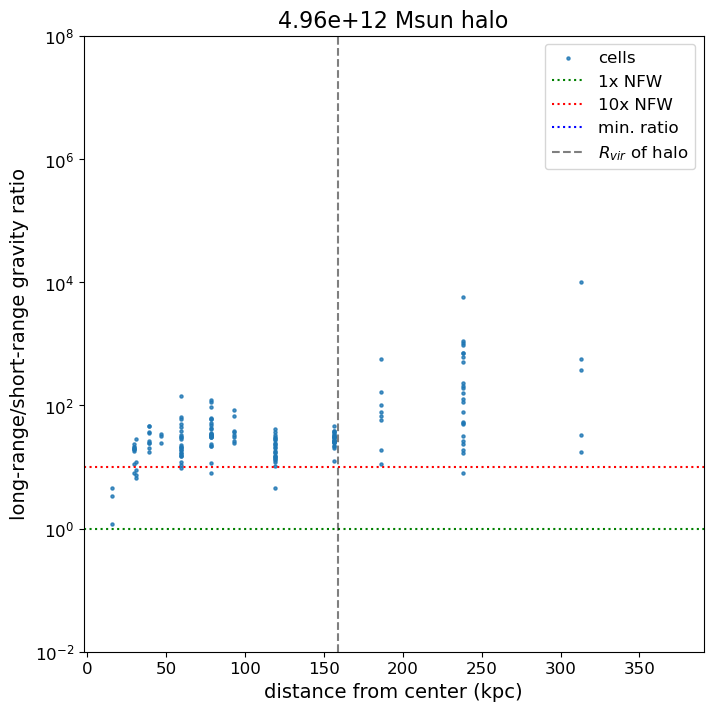

In [8]:
def sr_lr_comparison(
    cell_coords, sr_grid, lr_grid,
    Rvir, Mvir
    ):

    # Halo parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()
    grid_dist = grid_dist[dist_order]

    # Order short-range and long-range magnitudes.
    sr_mags = np.sqrt(np.sum(sr_grid**2, axis=1))
    lr_mags = np.sqrt(np.sum(lr_grid**2, axis=1))
    sr_mags = sr_mags[dist_order]
    lr_mags = lr_mags[dist_order]

    sr_mags[sr_mags == 0] = 1

    grav_ratio = lr_mags / sr_mags
    # grav_ratio = sr_mags / lr_mags
    print(f'min/max: {grav_ratio.min():.2e}/{grav_ratio.max():.2e}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':', label='1x NFW')
    ax.axhline(10, c='red', ls=':', label='10x NFW')
    ax.axhline(np.min(grav_ratio), c='blue', ls=':', label='min. ratio')
    ax.axvline(
        Rvir/kpc, c='black', ls='--', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('long-range/short-range gravity ratio')

    ax.set_ylim(1e-2,1e8)
    ax.set_yscale('log')
    plt.legend()
    plt.show()


sr_lr_comparison(
    cell_coords, gravity_sr, gravity_lr,
    halo_rvir, halo_Mvir
)

### NFW comparison.

dPsi/NFW: min=0.0, max=0.3570612955541272


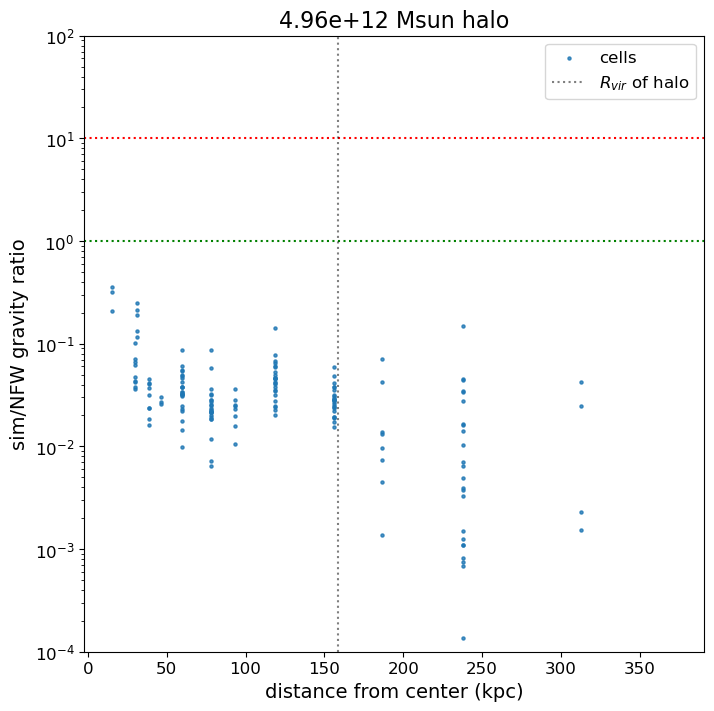

dPsi/NFW: min=0.4289727896833476, max=3.3094191141892573


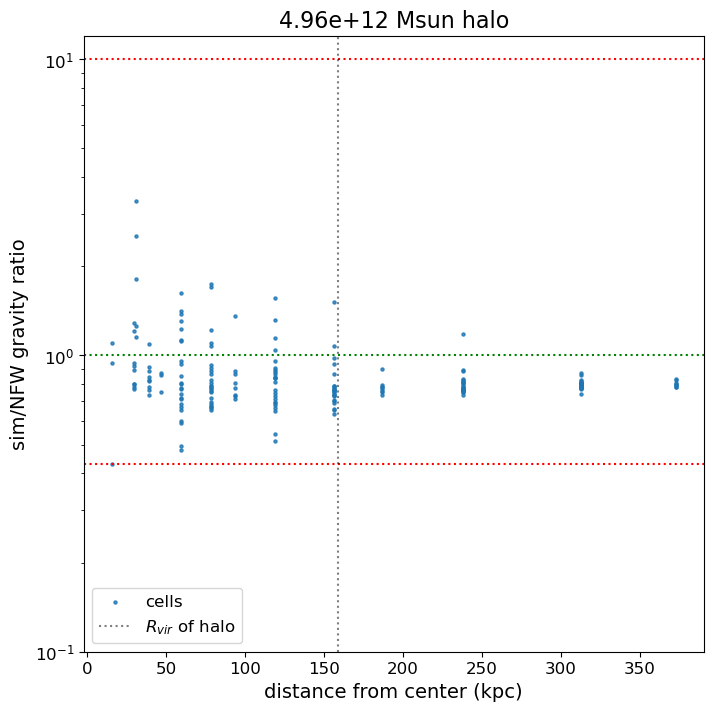

dPsi/NFW: min=0.47209367388790663, max=3.285603011733854


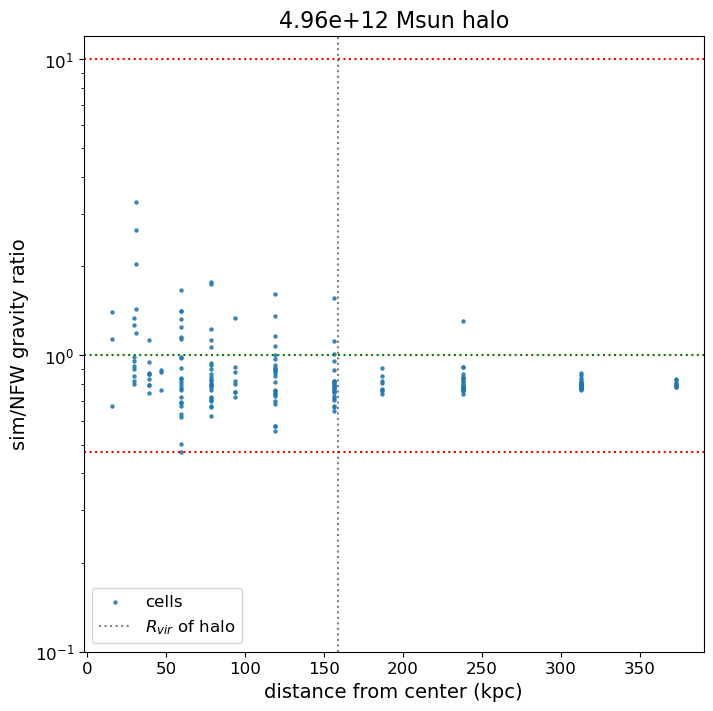

In [9]:
def gravity_comparison_NFW(
    cell_coords, dPsi_grid, Rvir, Mvir, cNFW, z=0,
    ylims = (1e-4, 1e2)
):

    # NFW parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun
    Rs = Rvir/cNFW
    rho0 = fct.scale_density_NFW(z, cNFW)

    # Calculate NFW value at cell coords.
    NFW_cells = np.array([
        fct.dPsi_dxi_NFW(x_i, z, rho0, Mvir, Rvir, Rs, 'HALO')
        for x_i in cell_coords
    ])/(kpc/s**2)
    NFW_mags = np.sqrt(np.sum(NFW_cells**2, axis=1))

    # Magnitudes of gravity in each cell.
    dPsi_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))/(kpc/s**2)

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()

    grid_dist = grid_dist[dist_order]
    dPsi_mags = dPsi_mags[dist_order]
    NFW_mags = NFW_mags[dist_order]

    grav_ratio = dPsi_mags/NFW_mags
    print(f'dPsi/NFW: min={np.min(grav_ratio)}, max={np.max(grav_ratio)}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )


    ax.set_ylim(ylims[0],ylims[1])

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('sim/NFW gravity ratio')

    ax.set_yscale('log')
    plt.legend()
    plt.show()


gravity_comparison_NFW(
    cell_coords, gravity_sr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)
gravity_comparison_NFW(
    cell_coords, gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0, ylims=(1e-1, 1.2*1e1)
)
gravity_comparison_NFW(
    cell_coords, gravity_sr+gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0, ylims=(1e-1, 1.2*1e1)
)

### Directionality of gravity grid.

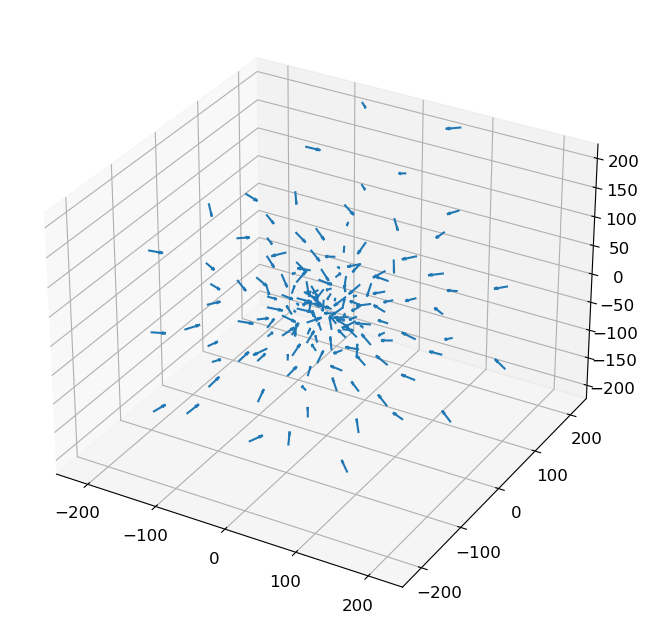

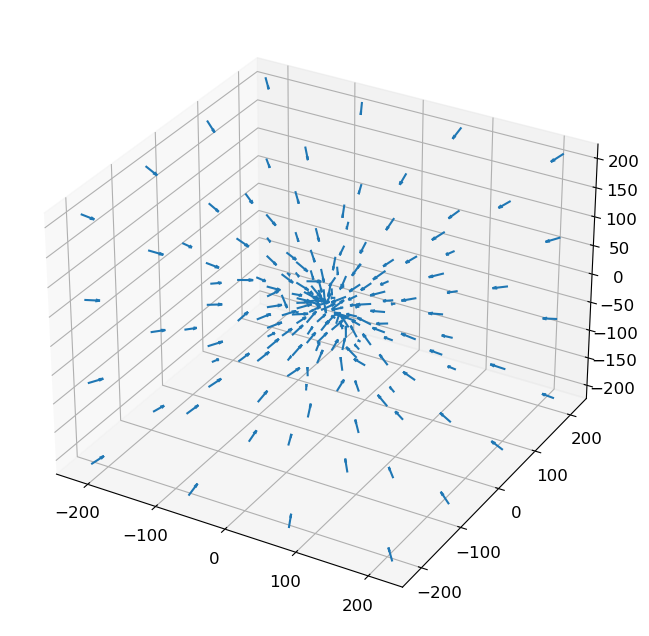

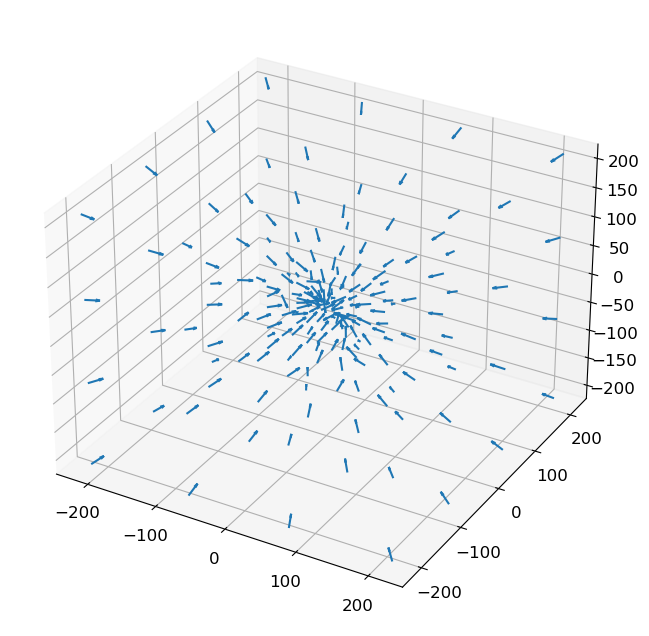

In [10]:
# %matplotlib widget
%matplotlib inline

def grid_arrows(
    cell_coords, dPsi_grid,
):

    # x,y,z of cell coordinates.
    pos_grid = cell_coords/kpc
    xGrid = pos_grid[:,0]
    yGrid = pos_grid[:,1]
    zGrid = pos_grid[:,2]

    # x,y,z of gravity grid.
    xPsi = dPsi_grid[:,0]
    yPsi = dPsi_grid[:,1]
    zPsi = dPsi_grid[:,2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    start, stop = 0, -1 
    # start, stop = 100, -1 
    ax.quiver(
        xGrid[start:stop], yGrid[start:stop], zGrid[start:stop], 
        xPsi[start:stop], yPsi[start:stop], zPsi[start:stop], 
        length=20, normalize=True
    )

    plt.show()

grid_arrows(cell_coords, gravity_sr)
grid_arrows(cell_coords, gravity_lr)
grid_arrows(cell_coords, gravity_sr+gravity_lr)